# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score, pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

## Part 1: Implementing Logistic Regression

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        def sigmoid_row(row):
            return self.__sigmoid(np.dot(weights, row))
        return np.apply_along_axis(sigmoid_row, axis=1, arr=X)
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        sums = []
        for j in range(y.size):
                sums.append(np.log(1 + np.exp(-(np.dot(x[j], weights) * y[j]))))
        return np.asarray(sums).mean(axis=0) + (1 / (2 * self.C )) * np.square(np.linalg.norm(weights))
        #return (np.log(1 + np.exp(-y * (weights @ x)))).mean() + (1 / (2 * self.C)) * np.linalg.norm(weights)


    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.losses = []

        for i in range(self.max_iter):
            delta = []
            for j in range(y.size):
                delta.append(y[j] * X_ext[j] * (1 - self.__sigmoid((np.dot(X_ext[j], self.weights_) * y[j]))))

            delta = np.negative(np.asarray(delta).mean(axis=0) - (1 / self.C ) * self.weights_)
            self.weights_ -= self.eta * delta
            self.losses.append({"iter": i, "loss": self.get_loss(X_ext, self.weights_, y)})

            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        results = self.predict_proba(X)
        results[results>=0.5] = 1
        results[results<0.5] = -1
        return results

In [5]:
from sklearn import datasets
from sklearn import metrics

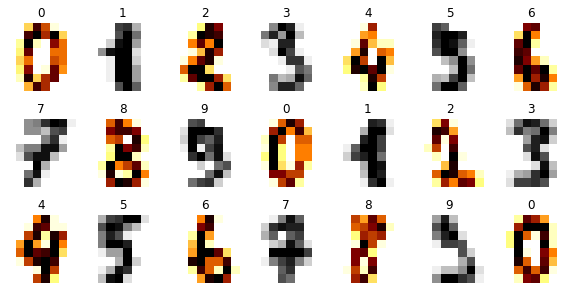

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, show=True):
    clf.fit(X_train, y_train)
    if show:
        disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
        disp.figure_.suptitle("Confusion Matrix")
        plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

c:\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


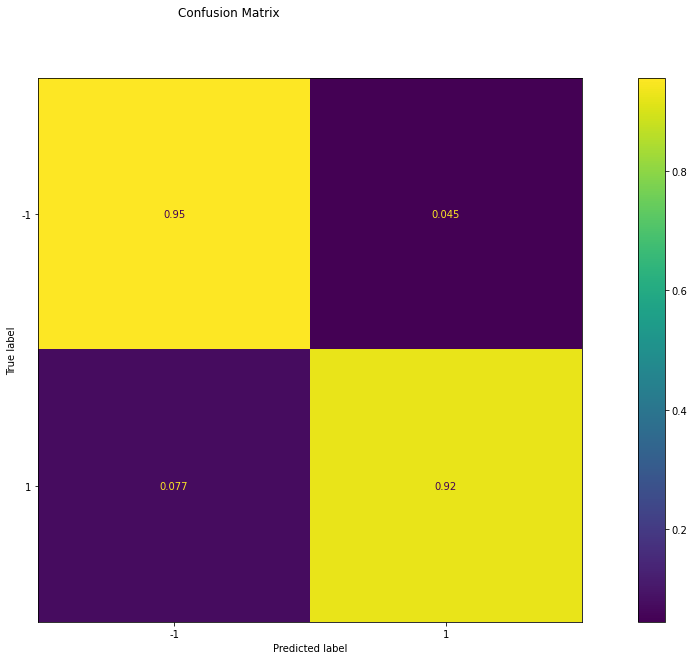

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

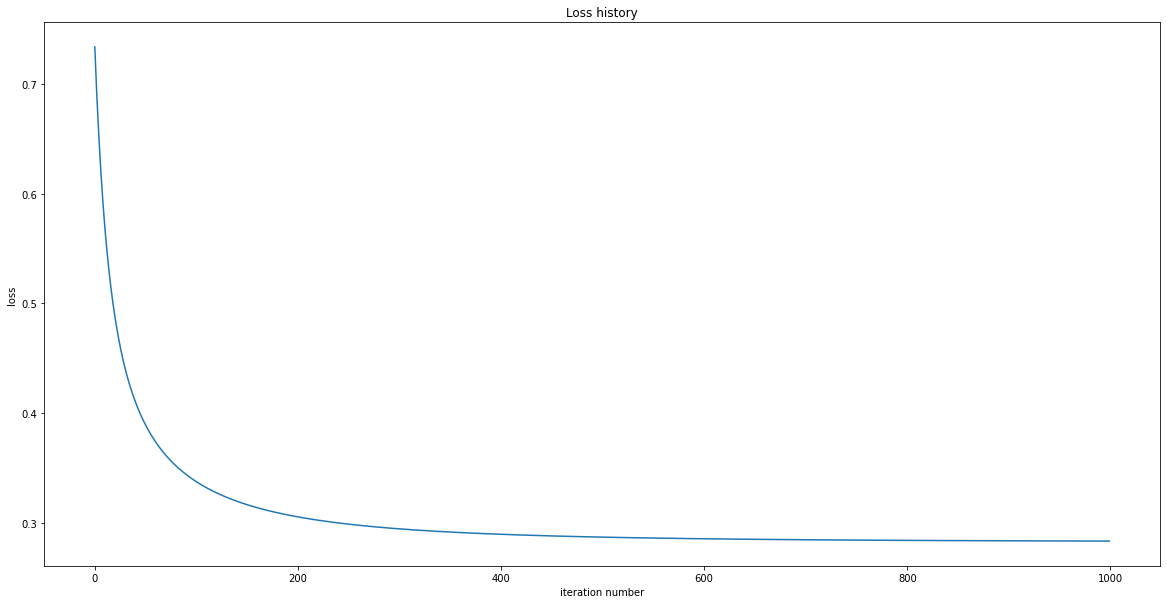

In [17]:
losses = pd.DataFrame(model.losses, columns=['iter', 'loss']).set_index('iter')
plt.title("Loss history")
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.plot(losses);

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
results = []
alphas = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

for alpha in alphas:
    model = CustomLogisticRegression(eta=alpha)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, show=False)
    results.append({"alpha": alpha, "loss": pd.DataFrame(model.losses, columns=['iter', 'loss']).set_index('iter')})

C:\Users\user\AppData\Local\Temp\ipykernel_14828\1210060042.py:42: RuntimeWarning: overflow encountered in exp
  sums.append(np.log(1 + np.exp(-(np.dot(x[j], weights) * y[j]))))
C:\Users\user\AppData\Local\Temp\ipykernel_14828\1210060042.py:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


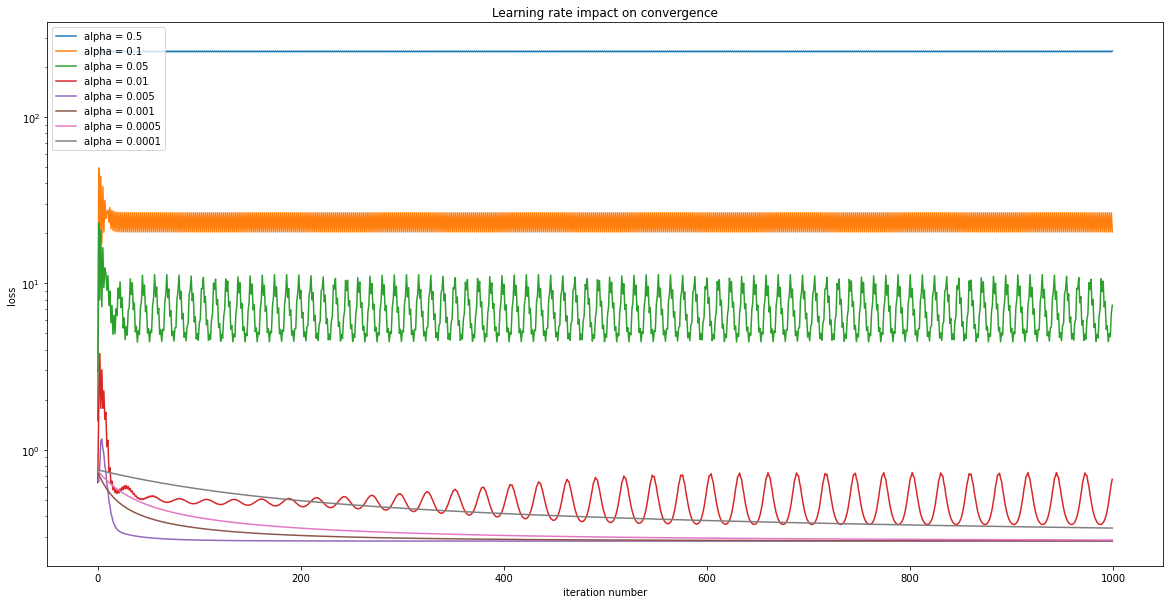

In [19]:
plt.title("Learning rate impact on convergence")
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.yscale('log')


for res in results:
    plt.plot(res['loss'], label=f'alpha = {res["alpha"]}')

plt.legend();


Alpha parameter (learning rate) controls how much the coefficients (and therefore the model) changes or learns each time it is updated. Too large values may make model fail to get the best results, and too low values will stop model from reaching the desired result in max_iter steps.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [20]:
results = []
regs = [0.1, 0.5, 1, 2, 5, 10, 50, 100]

for reg in regs:
    model = CustomLogisticRegression(C=reg)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, show=False)
    results.append({"c": reg, "train_acc": train_acc, "test_acc": test_acc})

results = pd.DataFrame(results, columns=['c', 'train_acc', 'test_acc']).set_index('c')

       train_acc  test_acc
c                         
0.1     0.887961  0.913889
0.5     0.903967  0.927778
1.0     0.910926  0.938889
2.0     0.913709  0.944444
5.0     0.915101  0.944444
10.0    0.915101  0.941667
50.0    0.914405  0.941667
100.0   0.914405  0.941667


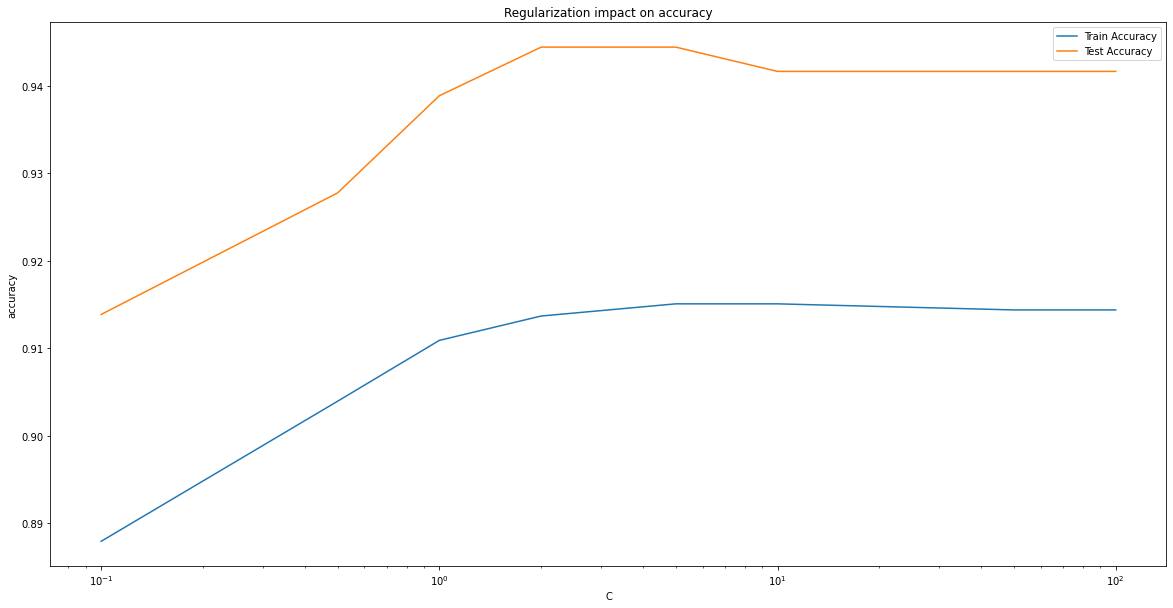

In [21]:
print(results)

plt.title("Regularization impact on accuracy")
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('accuracy')
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.legend();

Regularization will penalize the extreme parameters, the extreme values in the training data leads to overfitting.

A high value of C tells the model to give more weight to the training data. A lower value of C will indicate the model to give complexity more weight at the cost of fitting the data. Thus, a high Hyper Parameter value C indicates that training data is more important and reflects the real world data, whereas low value is just the opposite of this.

**(0.5 points)** Compare zero initialization and random initialization. 

In [22]:
model_zero = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(model_zero, X_train, y_train, X_test, y_test, show=False)

model_random = CustomLogisticRegression(zero_init=False)
train_acc_random, test_acc_random = fit_evaluate(model_random, X_train, y_train, X_test, y_test, show=False)

print(train_acc, test_acc)
print(train_acc_random, test_acc_random)

0.9116214335421016 0.9388888888888889
0.9109255393180237 0.9388888888888889


In [23]:
zero = pd.DataFrame(model_zero.losses, columns=['iter', 'loss']).set_index('iter')
random = pd.DataFrame(model_random.losses, columns=['iter', 'loss']).set_index('iter')

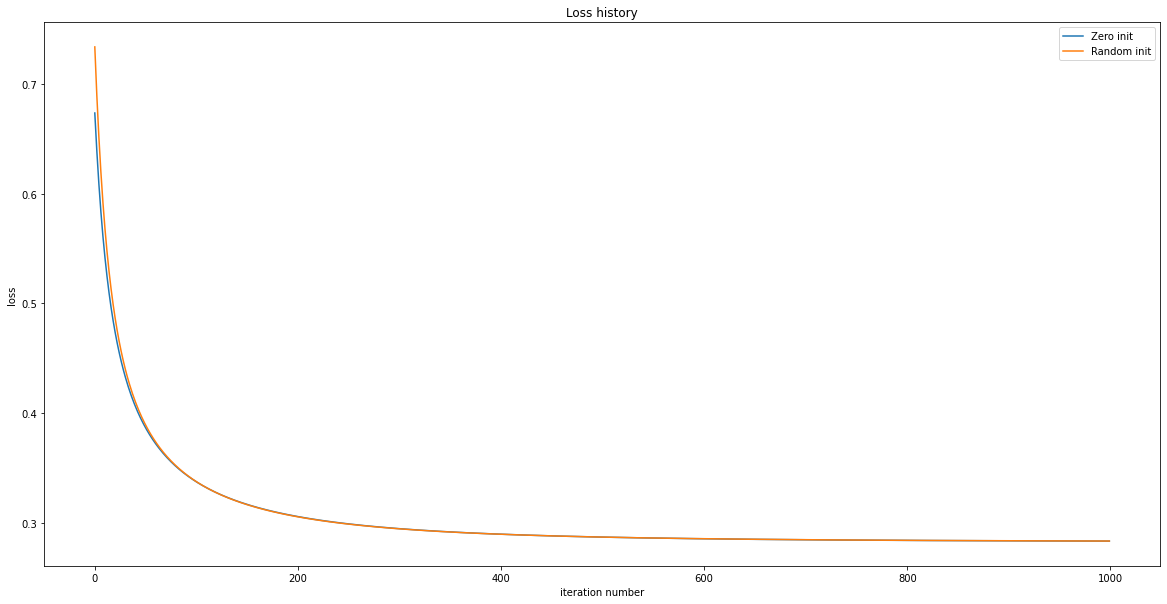

In [24]:
plt.title("Loss history")
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.plot(zero, label="Zero init");
plt.plot(random, label="Random init")
plt.legend();

There doesn't seem to be much difference between random init and zero init. However, zero init will produce the same result each time it is executed, and random init will produce different results, which may be better or worse each time. So if we run model infinite amount of times with random values and choose the best output, it will highly likely be better than the one with zero values.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [25]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return pairwise_distances(X, Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """

        class_weights = {class_: 0 for class_ in self.classes_}
        for i in range(len(y)):
            class_weights[y[i]] += weights[i]

        return np.array(list(class_weights.values()))
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """

        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)

            result = []
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / ( P + self.eps)

            for index in range(X.shape[0]):
                closest_index = np.argpartition(P[index], self.n_neighbors)[:self.n_neighbors]
                closest_classes = self.y[closest_index]
                closest_weights = np.take(weights_of_points[index], closest_index, axis=0)
                class_prediction = self.get_class_weights(closest_classes, closest_weights)
                class_prediction = class_prediction / class_prediction.sum()
                result.append(class_prediction)
            return np.array(result)

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        predictions = self.predict_proba(X)
        top_classes = predictions.argmax(axis=1)
        return np.choose(top_classes, self.classes_)

In [26]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [27]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [28]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])),
                   np.array([2,4,0]))

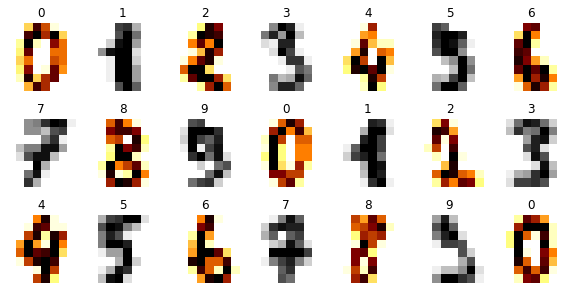

In [29]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [30]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [31]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

c:\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


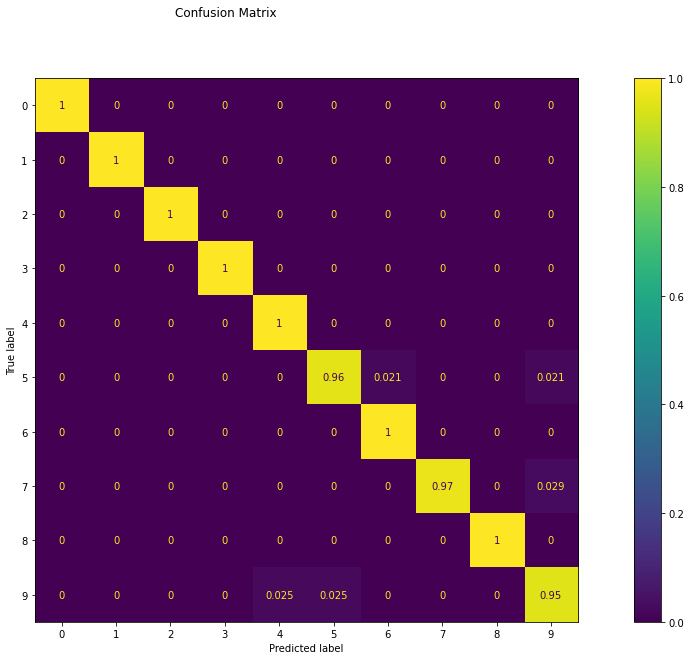

In [32]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [33]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

According to confusion matrix, the model has the following errors:
- 5 is misinterpreted as 6 or 9
- 7 is misinterpreted as 9
- 9 is misinterpreted as 4 or 5

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [34]:
n_options = range(1, 100)
results = []

for n_option in n_options:
    model = CustomKNeighborsClassifier(n_neighbors=n_option, weights='distance')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, show=False)
    results.append({'n': n_option, 'test_acc': test_acc})

results = pd.DataFrame(results, columns=['n', 'test_acc']).set_index('n')

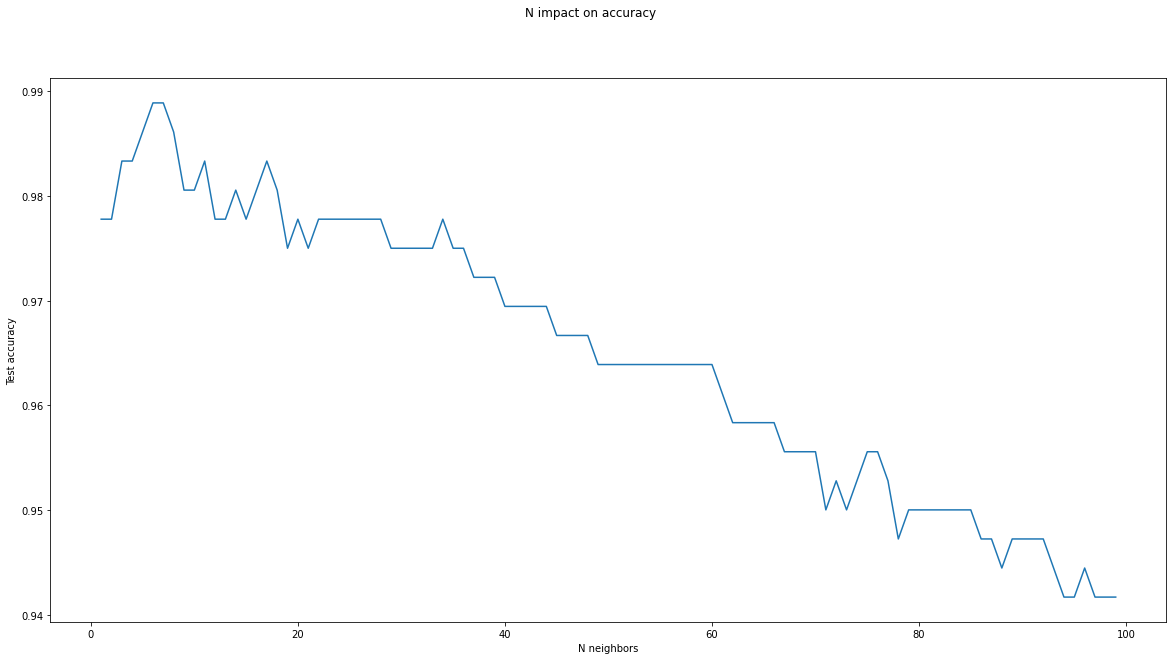

In [35]:

plt.suptitle('N impact on accuracy')
plt.xlabel('N neighbors')
plt.ylabel('Test accuracy')
plt.plot(results);

The best results for this dataset are achieved with N 5 and 6. Lower values tend to be impacted with noise, and higher values mix different clusters.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [36]:
n_options = range(1, 100)
results_uniform = []

for n_option in n_options:
    model = CustomKNeighborsClassifier(n_neighbors=n_option, weights='uniform')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test, show=False)
    results_uniform.append({'n': n_option, 'test_acc': test_acc})

results_uniform = pd.DataFrame(results_uniform, columns=['n', 'test_acc']).set_index('n')

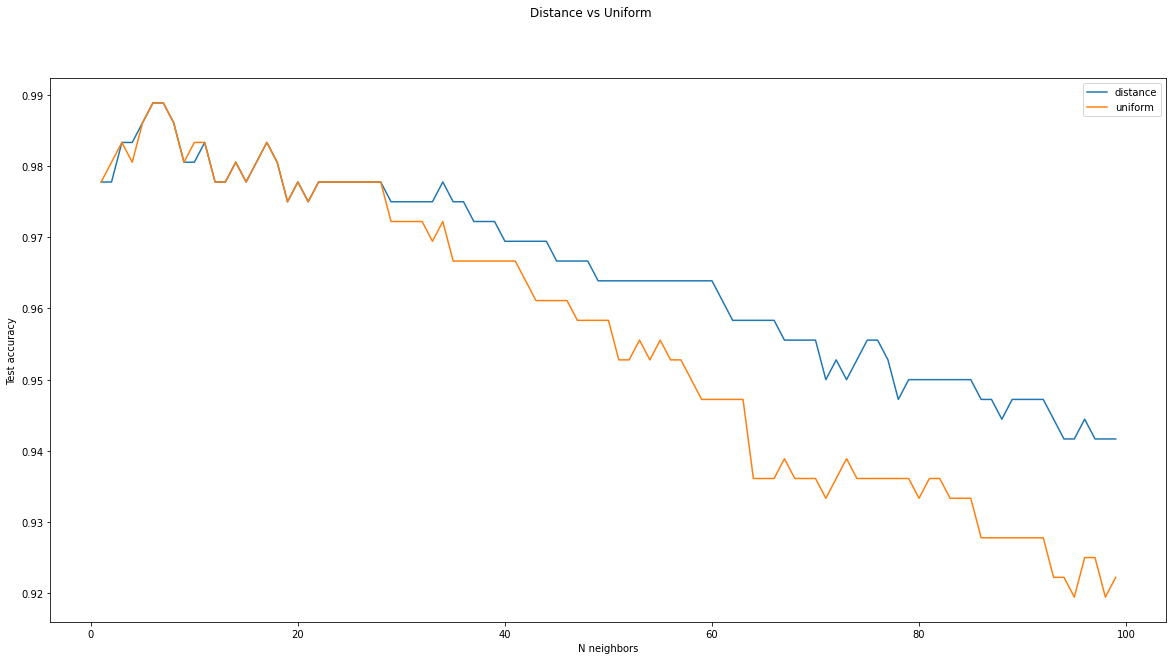

In [37]:
plt.suptitle('Distance vs Uniform')
plt.xlabel('N neighbors')
plt.ylabel('Test accuracy')
plt.plot(results, label='distance');
plt.plot(results_uniform, label='uniform')
plt.legend();

For this task both approaches have the same top accuracy, however, the accuracy decreases faster for uniform because far points of other class have the same impact as the close ones of the same class.
<br>One can choose uniform approach is the data is noisy.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

A good approach may be to penalise more for distance, i.e. use square root for weights:
<br>
$w_{i} = (\frac{1}{d_{i} + \epsilon})^2$

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

One can consider soving the task whenther to approve a loan or not based on age and income parameters. For this task, a distance approach is suitable.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [38]:
PATH = "./data/"

In [39]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
np.random.seed(42)

In [40]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

Sex distribution:
male      56.114
female    43.886
Name: Sex, dtype: float64


c:\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


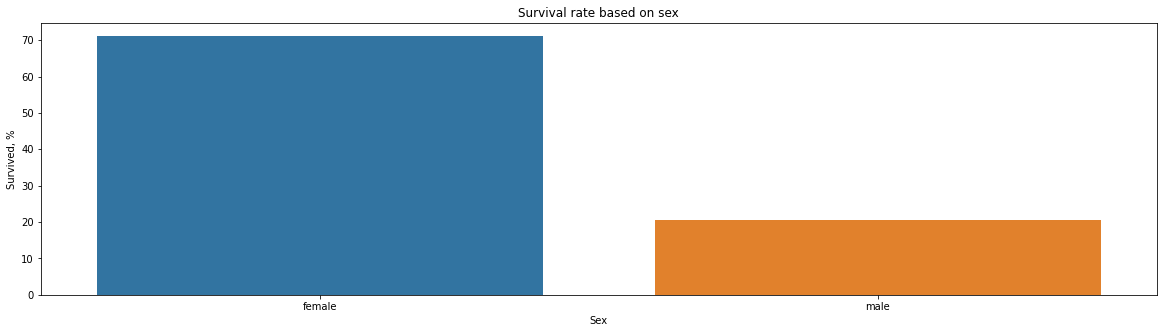

In [41]:
print('Sex distribution:')
print(data['Sex'].value_counts(normalize=True) * 100)

survivors = data[data['Survived'] == 1]
plt.rcParams['figure.figsize'] = (20, 5)

# All rows have sex column value, so no need to drop anything
sex_survivors = survivors.groupby('Sex').size().reset_index(name='Count')
sex_overall = data.groupby('Sex').size().reset_index(name='Count')
sex_survivors['Percentage'] = (sex_survivors['Count'] / sex_overall['Count']) * 100

sns.barplot('Sex','Percentage', data = sex_survivors)
plt.title('Survival rate based on sex')
plt.ylabel('Survived, %');

It looks like female passengers have a higher survival rate

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

All passengers: mean=38.349557430615874, median=39.0
Survived passengers: mean=40.548384760249164, median=43.0


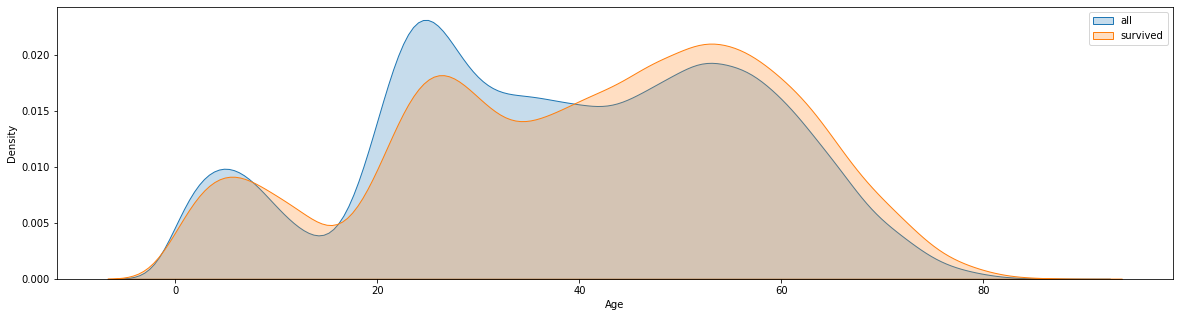

In [42]:
age_data = data[data['Age'].notnull()].copy()
age_data['Age'] = age_data.loc[:, 'Age'].astype('int64')
sns.kdeplot(data=age_data['Age'], shade=True, label='all')
sns.kdeplot(data=age_data.loc[age_data['Survived'] == 1, 'Age'], shade=True, label='survived')
plt.legend()

print(f"All passengers: mean={age_data['Age'].mean()}, median={age_data['Age'].median()}")
print(f"Survived passengers: mean={age_data.loc[age_data['Survived'] == 1, 'Age'].mean()}, median={age_data.loc[age_data['Survived'] == 1, 'Age'].median()}")

It looks like there is a lower survival rate for passengers from 18 to 40 years old and a higher rate for elder passengers.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Text(0, 0.5, 'Survived, %')

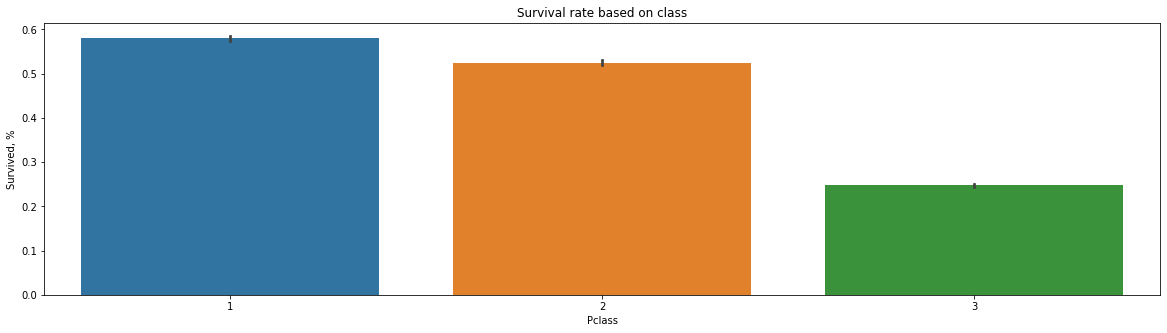

In [43]:
class_data = data[data['Pclass'].notnull()]

sns.barplot(data = class_data, x='Pclass', y='Survived')
plt.title('Survival rate based on class')
plt.ylabel('Survived, %')

Text(0, 0.5, 'Survived, %')

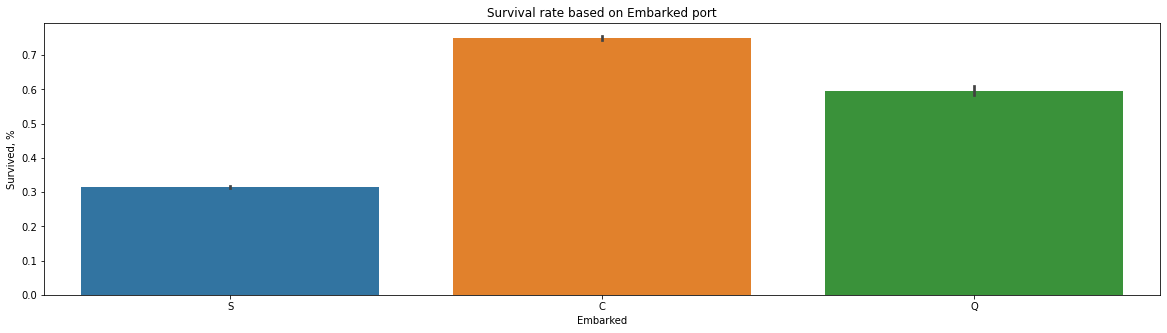

In [44]:
embarked_data = data[data['Embarked'].notnull()]

sns.barplot(data = embarked_data, x='Embarked', y='Survived')
plt.title('Survival rate based on Embarked port')
plt.ylabel('Survived, %')

The better the class is, the higher is survival chance.
The best survival rate is for passengers embarked at C, worse for Q and the worst for S

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [45]:
percent_missing = data.isnull().sum() * 100 / len(data)
percent_missing

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

The rows with data missing for age, ticket fare and embarked can be dropped or replaced with mean as the amount of such values is small.
For rows with missing cabin value a new type - unknown - can be introduced to replace the missing values.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [46]:
data['Cabin'] = data['Cabin'].fillna('U')
data['Deck'] = data['Cabin'].map(lambda x: str(x)[0] if str(x) != 'nan' else np.NAN)
data['Family_Size'] = data['SibSp']+data['Parch']
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Alone'] = LabelEncoder().fit_transform(data['Family_Size'] == 0)
data['Age'].fillna((data['Age'].mean()), inplace=True)
data['Fare'].fillna((data['Fare'].mean()), inplace=True)

In [47]:
data = data.drop(columns=['Name', 'Cabin', 'Ticket'])
data = data.dropna()

In [48]:
print(data.head())
print(data.shape)

             Survived  Pclass  Sex        Age  SibSp  Parch   Fare Embarked  \
PassengerId                                                                   
0                   1       1    1  38.355472      2      0  27.14        S   
1                   0       3    1  38.355472      0      0  13.35        S   
2                   0       3    1   0.330000      1      2  71.29        S   
3                   0       3    1  19.000000      0      0  13.04        S   
4                   1       3    1  25.000000      0      0   7.76        S   

            Deck  Family_Size  Alone  
PassengerId                           
0              C            2      0  
1              U            0      1  
2              U            3      0  
3              U            0      1  
4              U            0      1  
(99750, 11)


In [49]:
data=pd.get_dummies(data)
data.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family_Size,Alone,Embarked_C,...,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
PassengerId,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,38.355472,2,0,27.14,2,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0,3,1,38.355472,0,0,13.35,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,1,0.330000,1,2,71.29,3,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,3,1,19.000000,0,0,13.04,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,1,3,1,25.000000,0,0,7.76,0,1,0,...,1,0,0,0,0,0,0,0,0,1
5,0,2,1,35.000000,0,0,6.71,0,1,0,...,1,0,0,0,0,0,0,0,0,1
6,0,3,1,7.000000,0,0,9.77,0,1,0,...,1,0,0,0,0,0,0,0,0,1
7,1,3,0,6.000000,1,2,31.50,3,0,0,...,1,0,0,0,0,0,0,0,0,1
8,0,1,1,27.000000,2,1,73.02,3,0,0,...,1,1,0,0,0,0,0,0,0,0


In [50]:
y = data['Survived']
X = data.drop('Survived', axis=1)

In [51]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
log = LogisticRegression(penalty='l1', solver='liblinear')

scores = cross_val_score(knn, X, y, cv=5)
print("kNN: %0.5f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(log, X, y, cv=5)
print("LR: %0.5f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

kNN: 0.70838 accuracy with a standard deviation of 0.00
LR: 0.77229 accuracy with a standard deviation of 0.00


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [52]:
model_log = make_pipeline(StandardScaler(), LogisticRegression())
model_log.get_params().keys()
parameters = [{'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10],
              'logisticregression__solver': ['liblinear', 'saga'],
              'logisticregression__penalty': ['l1', 'l2', 'none'],
               'logisticregression__tol': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             },
              {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10],
              'logisticregression__solver': ['saga'],
              'logisticregression__penalty': ['elasticnet'],
              'logisticregression__l1_ratio': [0.3, 0.5, 0.7],
               'logisticregression__tol': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             }]
search_log = GridSearchCV(model_log, parameters, n_jobs = -1, cv = 5, scoring = 'accuracy', verbose=1)
search_log.fit(X, y)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


c:\python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
175 fits failed out of a total of 1575.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "c:\python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python39\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\python39\lib\site-packages

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__penalty': ['l1', 'l2', 'none'],
                          'logisticregression__solver': ['liblinear', 'saga'],
                          'logisticregression__tol': [0.001, 0.01, 0.1, 1, 10,
                                                      100, 1000]},
                         {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
                          'logisticregression__l1_ratio': [0.3, 0.5, 0.7],
                          'logisticregression__penalty': ['elasticnet'],
                          'logisticregression__solver': ['saga'],
                          'logisticregression__tol': [0.001, 0.01, 0.1, 1, 10,


In [53]:
print("Best parameters are:", search_log.best_params_)
print("Best accuracy achieved:",search_log.best_score_)

Best parameters are: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga', 'logisticregression__tol': 0.001}
Best accuracy achieved: 0.7742556390977444


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.